In [1]:
%matplotlib inline

In [2]:
!pip install scikit-optimize

  Using cached scikit_optimize-0.9.0-py2.py3-none-any.whl (100 kB)
  Using cached scikit_learn-1.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached pyaml-21.10.1-py2.py3-none-any.whl (24 kB)
     |████████████████████████████████| 701 kB 488 kB/s eta 0:00:01
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)



# Comparing initial point generation methods

Holger Nahrstaedt 2020

.. currentmodule:: skopt

Bayesian optimization or sequential model-based optimization uses a surrogate
model to model the expensive to evaluate function `func`. There are several
choices for what kind of surrogate model to use. This notebook compares the
performance of:

* Halton sequence,
* Hammersly sequence,
* Sobol sequence and
* Latin hypercube sampling

as initial points. The purely random point generation is used as
a baseline.


In [3]:
print(__doc__)
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt

Automatically created module for IPython interactive environment


## Toy model

We will use the :class:`benchmarks.hart6` function as toy model for the expensive function.
In a real world application this function would be unknown and expensive
to evaluate.



In [4]:
from skopt.benchmarks import hart6 as hart6_
# from skopt.benchmarks import hart3 as hart3_
# redefined `hart6` to allow adding arbitrary "noise" dimensions
def hart6(x, noise_level=0.):
    return hart6_(x[:6]) + noise_level * np.random.randn()

def hart3(x, noise_level=0.):
    return hart6_(x[:3] + [0,0,0]) + noise_level * np.random.randn()

# def hart3(x, noise_level=0.):
#     return hart3_(x[:3]) + noise_level * np.random.randn()

from skopt.benchmarks import branin as _branin

def branin(x, noise_level=0.):
    return _branin(x) + noise_level * np.random.randn()

In [5]:
from matplotlib.pyplot import cm
import time
from skopt import gp_minimize, forest_minimize, dummy_minimize

def plot_convergence(result_list, true_minimum=None, yscale=None, title="Convergence plot"):

    ax = plt.gca()
    ax.set_title(title)
    ax.set_xlabel("Number of iterations")
    ax.set_ylabel(r"Gap metric")
    ax.grid()
    if yscale is not None:
        ax.set_yscale(yscale)
    colors = cm.hsv(np.linspace(0.25, 1.0, len(result_list)))

    for results, color in zip(result_list, colors):
        name, results = results
        n_calls = len(results[0].x_iters)
        iterations = range(1, n_calls + 1)
        mins = [[np.min(r.func_vals[:i]) for i in iterations]
                for r in results]
        # ax.plot(iterations, (np.mean(mins, axis=0) - np.mean(mins, axis=0)[0])/(true_minimum - np.mean(mins, axis=0)[0]), c=color, label=name)
        ax.errorbar(iterations, (np.mean(mins, axis=0) - np.mean(mins, axis=0)[0])/(true_minimum - np.mean(mins, axis=0)[0]),
                    yerr=np.std((mins - np.mean(mins, axis=0)[0])/(true_minimum - np.mean(mins, axis=0)[0]), axis=0), c=color, label=name)
        print(np.std((mins - np.mean(mins, axis=0)[0])/(true_minimum - np.mean(mins, axis=0)[0]), axis=0))    
    # if true_minimum:
    #     ax.axhline(true_minimum, linestyle="--",
    #                color="r", lw=1,
    #                label="True minimum")
    ax.legend(loc="best")
    return ax


def run(minimizer, acq_func,
        n_initial_points=25, n_repeats=1):
    return [minimizer(func, bounds, n_initial_points=n_initial_points,
                      acq_func = acq_func,
                      n_calls=n_calls, random_state=n)
            for n in range(n_repeats)]


def run_measure(acq_func, n_initial_points=25):
    start = time.time()
    # n_repeats must set to a much higher value to obtain meaningful results.
    n_repeats = 1
    res = run(gp_minimize, acq_func,
              n_initial_points=n_initial_points, n_repeats=n_repeats)
    duration = time.time() - start
    # print("%s %s: %.2f s" % (initial_point_generator,
    #                          str(init_point_gen_kwargs),
    #                          duration))
    return res

## Objective

The objective of this example is to find one of these minima in as
few iterations as possible. One iteration is defined as one call
to the :class:`benchmarks.hart6` function.

We will evaluate each model several times using a different seed for the
random number generator. Then compare the average performance of these
models. This makes the comparison more robust against models that get
"lucky".



# New Section

In [6]:
#@title Test Function
example = "hart3" #@param ["branin", "hart3", "hart6"]
from functools import partial
# example = "branin"

if example == "hart6":
    func = partial(hart6, noise_level=0.1)
    bounds = [(0., 1.), ] * 6
    true_minimum = -3.32237
    n_calls = 100
    n_initial_points = 25
    yscale = None
    title = "Convergence plot - hart6"
if example == "hart3":
    func = partial(hart3, noise_level=0.1)
    bounds = [(0., 1.), ] * 3
    true_minimum = -3.32237
    n_calls = 100
    n_initial_points = 25
    yscale = None
    title = "Convergence plot - hart3"
else:
    func = partial(branin, noise_level=2.0)
    bounds = [(-5.0, 10.0), (0.0, 15.0)]
    true_minimum = 0.397887
    n_calls = 100
    n_initial_points = 25
    yscale="log"
    title = "Convergence plot - branin"

In [7]:
from skopt.utils import cook_initial_point_generator

# Random search
# dummy_res = run_measure("random", n_initial_points)
# lhs = cook_initial_point_generator(
#     "lhs", lhs_type="classic", criterion=None)
# lhs_res = run_measure(lhs, n_initial_points)
# lhs2 = cook_initial_point_generator("lhs", criterion="maximin")
# lhs2_res = run_measure(lhs2, n_initial_points)
# sobol = cook_initial_point_generator("sobol", randomize=False,
                                    #  min_skip=1, max_skip=100)
sobol_res = run_measure("LCB", n_initial_points)
halton_res = run_measure("EI", n_initial_points)
hammersly_res = run_measure("PI", n_initial_points)
grid_res = run_measure("gp_hedge", n_initial_points)

/home/hao/miniconda3/envs/NNBO/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Note that this can take a few minutes.



In [9]:
# # Random search
# dummy_res = run_measure("random", n_initial_points)
# lhs2 = cook_initial_point_generator("lhs", criterion="maximin")
# lhs2_res = run_measure(lhs2, n_initial_points)

ValueError: expected acq_func to be in gp_hedge,EI,LCB,PI,EIps,PIps, got random

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.

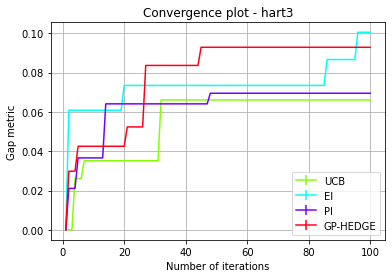

In [10]:
plot = plot_convergence([("UCB", sobol_res),
                        ("EI", halton_res),
                        ("PI", hammersly_res),
                        ("GP-HEDGE", grid_res)],
                        true_minimum=true_minimum,
                        yscale=yscale,
                        title=title)
plt.show()

This plot shows the value of the minimum found (y axis) as a function
of the number of iterations performed so far (x axis). The dashed red line
indicates the true value of the minimum of the :class:`benchmarks.hart6`
function.



Test with different n_random_starts values



In [11]:
lhs2 = cook_initial_point_generator("lhs", criterion="maximin")
lhs2_15_res = run_measure(lhs2, 12)
lhs2_20_res = run_measure(lhs2, 14)
lhs2_25_res = run_measure(lhs2, 16)

ValueError: expected acq_func to be in gp_hedge,EI,LCB,PI,EIps,PIps, got <skopt.sampler.lhs.Lhs object at 0x7f543a38ce50>

n_random_starts = 10 produces the best results



In [ ]:
# plot = plot_convergence([("random - 10", dummy_res),
#                         ("lhs_maximin - 10", lhs2_res),
#                         ("lhs_maximin - 12", lhs2_15_res),
#                         ("lhs_maximin - 14", lhs2_20_res),
#                         ("lhs_maximin - 16", lhs2_25_res)],
#                         true_minimum=true_minimum,
#                         yscale=yscale,
#                         title=title)
#
# plt.show()

In [ ]:
plot = plot_convergence([("lhs_maximin - 12", lhs2_15_res),
                        ("lhs_maximin - 14", lhs2_20_res),
                        ("lhs_maximin - 16", lhs2_25_res)],
                        true_minimum=true_minimum,
                        yscale=yscale,
                        title=title)

plt.show()